In [1]:
import math
import numpy as np
import wandb
import pickle
import os
import shapely.wkt as wkt
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString
from torch_geometric.transforms import LineGraph

import gzip
import xml.etree.ElementTree as ET

import torch
import torch_geometric
from torch_geometric.data import Data

import processing_io as pio
import sys
import os
import joblib
import json

# Add the 'scripts' directory to the Python path
scripts_path = os.path.abspath(os.path.join('..'))
if scripts_path not in sys.path:
    sys.path.append(scripts_path)

import gnn_io as gio
import gnn_architectures as garch

# Assuming 'highway_mapping' and 'encode_modes' are defined as in your context
highway_mapping = {
    'residential': 0, 'tertiary': 1, 'living_street': 2, 'secondary': 3, 
    'primary': 4, 'trunk_link': 5, 'primary_link': 6, 'motorway': 7, 
    'service': 8, 'unclassified': 9, 'secondary_link': 10, 
    'pedestrian': 11, 'trunk': 12, 'motorway_link': 13, 
    'construction': 14, 'tertiary_link': 15, np.nan: -1
}



In [2]:
# Parameters to define
run_path = '/home/enatterer/Development/gnn_predicting_effects_of_traffic_policies/data/runs_1234/hidden_64_hidden_layer_str_[64_64]_/'
model_path = run_path +  'trained_model/model.pth'
data_created_during_training = run_path + 'data_created_during_training/'
indices_of_datasets_to_use = [0, 1, 3, 4]

scaler_y = joblib.load(data_created_during_training + 'y_scaler.pkl')
scaler_x = joblib.load(data_created_during_training + 'x_scaler.pkl')
scaler_pos = joblib.load(data_created_during_training + 'pos_scaler.pkl')

# Load the test dataset created during training
test_set_dl = torch.load(data_created_during_training + 'test_dl.pt')

# Load the DataLoader parameters
with open(data_created_during_training + 'test_loader_params.json', 'r') as f:
    test_set_dl_loader_params = json.load(f)

In [3]:
test_data = "../../data/test_data/gdf_pop_1pm_policy_in_5_6_7.geojson"
base_case = "../../data/test_data/gdf_basecase_mean_pop_1pm.geojson"

test_data = gpd.read_file(test_data)
base_case = gpd.read_file(base_case)

test_input_linegraph = pio.create_test_data_object(base_case=base_case, test_data = test_data) # check this function if there have been changes in the features of the data
test_data_list = [test_input_linegraph] # we do it for just one test data object, for now.

In [4]:
# Example of how to initialize your model
in_channels = 6  # Example value
out_channels = 1  # Example value
hidden_layers_base_for_point_net_conv = 64
hidden_layer_structure = [64,64]  # Example value

# Initialize the model
model = garch.MyGnn(in_channels=in_channels, out_channels=out_channels, hidden_layers_base_for_point_net_conv=hidden_layers_base_for_point_net_conv, hidden_layer_structure=hidden_layer_structure)

# Load the model state dictionary
model.load_state_dict(torch.load(model_path))

Initializing PointNetConv(local_nn=Sequential(
  (0): Linear(in_features=6, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
), global_nn=Sequential(
  (0): Linear(in_features=64, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=64, bias=True)
))
Initializing 0.weight with kaiming_normal
Initializing 0.bias with zeros
Initializing 2.weight with kaiming_normal
Initializing 2.bias with zeros
Initializing 0.weight with kaiming_normal
Initializing 0.bias with zeros
Initializing 2.weight with kaiming_normal
Initializing 2.bias with zeros
Initializing 4.weight with kaiming_normal
Initializing 4.bias with zeros
Initializing Linear(in_features=6, out_features=64, bias=True)
Initializing Linear(in_features=64, out_features=64, bias=True)
Initializing Linear(in_features=64, out_features=32, bias=True)
Initializing Linear(in_features=32, 

<All keys matched successfully>

In [6]:
dataset_only_relevant_dimensions = gio.cut_dimensions(dataset=test_data_list, indices_of_dimensions_to_keep=indices_of_datasets_to_use)

In [8]:
# Call this function during training without the scalars and with the directory path, and during the testing with the saved scalars and without a directory path to save.
def normalize_dataset_with_existing_scalers(dataset, y_scalar=None, pos_scalar=None, x_scalar_list = None):
    dataset = normalize_x_values_with_existing_scalers(dataset, x_scalar_list)
    dataset = normalize_positional_features_with_existing_scaler(dataset, pos_scalar)
    dataset = normalize_y_values_with_existing_scaler(dataset, y_scalar)
    return dataset

def normalize_x_values_with_existing_scalers(dataset, x_scaler_list):
    print("x before and after ")
    print(dataset[0].x[:10])
    shape_of_x = dataset[0].x.shape[1]

    for i in range(shape_of_x):
        scaler = x_scaler_list[i]

        for data in dataset:
            data_x_dim = replace_invalid_values(data.x[:, i].reshape(-1, 1))
            normalized_x_dim = torch.tensor(scaler.transform(data_x_dim.numpy()), dtype=torch.float)
            if i == 0:
                data.normalized_x = normalized_x_dim
            else:
                data.normalized_x = torch.cat((data.normalized_x, normalized_x_dim), dim=1)

    for data in dataset:
        data.x = data.normalized_x
        del data.normalized_x
    print(dataset[0].x[:10])
    return dataset

def normalize_positional_features_with_existing_scaler(dataset, pos_scaler):
    print("pos before and after ")
    print(dataset[0].pos[:10])
    for data in dataset:
        data.pos = torch.tensor(pos_scaler.transform(data.pos.numpy()), dtype=torch.float)
    print(dataset[0].pos[:10])
    return dataset

def normalize_y_values_with_existing_scaler(dataset, y_scaler):
    print("y before and after")
    print(dataset[0].y[:10])
    for data in dataset:
        data.y = torch.tensor(y_scaler.transform(data.y.reshape(-1, 1).numpy()), dtype=torch.float)
    print(dataset[0].y[:10])
    return dataset

def replace_invalid_values(tensor):
    tensor[tensor != tensor] = 0  # replace NaNs with 0
    tensor[tensor == float('inf')] = 0  # replace inf with 0
    tensor[tensor == float('-inf')] = 0  # replace -inf with 0
    return tensor

In [9]:
dataset_normalized = normalize_dataset_with_existing_scalers(dataset_only_relevant_dimensions, y_scalar=scaler_y, x_scalar_list=scaler_x, pos_scalar=scaler_pos)

x before and after 
tensor([[   7.0741,  480.0000,    0.0000,    4.0000],
        [   9.1481,  480.0000, -240.0000,    3.0000],
        [   2.0000,  960.0000, -480.0000,    3.0000],
        [   7.1852,  960.0000,    0.0000,    4.0000],
        [   8.1111,  480.0000,    0.0000,    4.0000],
        [   5.4444,  480.0000,    0.0000,    4.0000],
        [   5.4444,  480.0000,    0.0000,    4.0000],
        [   0.0000,  240.0000,    0.0000,    5.0000],
        [  17.1111,  480.0000, -240.0000,    3.0000],
        [   6.7037,  480.0000,    0.0000,    4.0000]])
tensor([[ 0.0795, -0.5715,  0.4442,  0.5976],
        [ 0.2217, -0.5715, -0.0806,  0.1290],
        [-0.2682, -0.3785, -0.6054,  0.1290],
        [ 0.0871, -0.3785,  0.4442,  0.5976],
        [ 0.1506, -0.5715,  0.4442,  0.5976],
        [-0.0321, -0.5715,  0.4442,  0.5976],
        [-0.0321, -0.5715,  0.4442,  0.5976],
        [-0.4052, -0.6681,  0.4442,  1.0662],
        [ 0.7673, -0.5715, -0.0806,  0.1290],
        [ 0.0541, -0.5715

In [13]:
test_dl = gio.create_dataloader(dataset=dataset_normalized, is_train=False, batch_size=16, train_ratio=0, is_test=True)

Total dataset length: 1


In [14]:
def validate_model(model, valid_dl, loss_func, device):
    model.eval()
    val_loss = 0
    num_batches = 0
    
    actual_vals = []
    predictions = []
    
    with torch.inference_mode():
        for idx, data in enumerate(valid_dl):
            input_node_features, targets = data.x.to(device), data.y.to(device)
            predicted = model(data.to(device))
            actual_vals.append(targets)
            predictions.append(predicted)
            val_loss += loss_func(predicted, targets).item()
            num_batches += 1
            
    actual_vals_cat = torch.cat(actual_vals)
    predictions_cat = torch.cat(predictions)
    r_squared = compute_r2_torch(preds=predictions_cat, targets=actual_vals_cat)
    return val_loss / num_batches if num_batches > 0 else 0, r_squared, actual_vals, predictions

def validate_one_model(model, data, loss_func, device):
    model.eval()
    val_loss = 0
    num_batches = 0
    
    # actual_vals = []
    # predictions = []
    
    with torch.inference_mode():
        # for idx, data in enumerate(valid_dl):
        input_node_features, targets = data.x.to(device), data.y.to(device)
        predicted = model(data.to(device))
        val_loss += loss_func(predicted, targets).item()
        num_batches += 1
    r_squared = compute_r2_torch(preds=predicted, targets=targets)
    return val_loss / num_batches if num_batches > 0 else 0, r_squared, targets, predicted

def compute_r2_torch(preds, targets):
    """Compute R^2 score using PyTorch."""
    mean_targets = torch.mean(targets)
    ss_tot = torch.sum((targets - mean_targets) ** 2)
    ss_res = torch.sum((targets - preds) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
loss_fct = torch.nn.MSELoss()
test_loss, r_squared, actual_vals, predictions = validate_one_model(model, test_set_dl[0], loss_fct, device)
print(f'Test Loss: {test_loss}')
print(f'r_squared: {r_squared}')
print(f'actual_vals shape: {len(actual_vals)}')
print(f'predictions shape: {len(predictions)}')

Test Loss: 0.24520263075828552
r_squared: 0.7547973990440369
actual_vals shape: 31216
predictions shape: 31216


In [16]:
test_set_dl[0]

Data(x=[31216, 4], edge_index=[2, 59135], y=[31216, 1], pos=[31216, 2])

In [19]:
def data_to_geodataframe(data, original_gdf, predicted_values):
    # Extract the edge index and node features
    node_features = data.x.cpu().numpy()
    target_values = data.y.cpu().numpy()
    predicted_values = predicted_values.cpu().numpy() if isinstance(predicted_values, torch.Tensor) else predicted_values

    # Create edge data
    edge_data = {
        'from_node': original_gdf["from_node"].values,
        'to_node': original_gdf["to_node"].values,
        'vol_base_case': node_features[:, 0],  # Assuming capacity is the first feature, and so on
        'capacity_base_case': node_features[:, 1],  
        'capacity_reduction': node_features[:, 2],  
        'highway': node_features[:, 3],  
        'vol_car_change_actual': target_values.squeeze(),  # Assuming target values are car volumes
        'vol_car_change_predicted': predicted_values.squeeze()
    }
    # Convert to DataFrame
    edge_df = pd.DataFrame(edge_data)
    # Create LineString geometry
    edge_df['geometry'] = original_gdf["geometry"].values
    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(edge_df, geometry='geometry')
    return gdf

In [20]:
# Example usage
gdf = data_to_geodataframe(data=test_set_dl[0], original_gdf=test_data, predicted_values=predictions)

In [21]:
gdf.head()

,from_node,to_node,vol_base_case,capacity_base_case,capacity_reduction,highway,vol_car_change_actual,vol_car_change_predicted,geometry
0,24972409,24972408,0.079526,-0.571546,0.444202,0.597637,0.379267,-0.020474,"LINESTRING (2.33869 48.85181, 2.33847 48.85181)"
1,5904976363,24983651,0.221656,-0.571546,-0.080601,0.129027,-0.623954,-0.159714,"LINESTRING (2.33874 48.85242, 2.33872 48.85229)"
2,24983651,5904976363,-0.268184,-0.378476,-0.605404,0.129027,1.382488,0.531271,"LINESTRING (2.33872 48.85229, 2.33874 48.85242)"
3,664205947,24972376,0.087140,-0.378476,0.444202,0.597637,0.809219,0.625733,"LINESTRING (2.33994 48.85200, 2.33986 48.85181)"
4,24972376,24972375,0.150591,-0.571546,0.444202,0.597637,0.845048,0.579695,"LINESTRING (2.33986 48.85181, 2.33909 48.85152)"


In [22]:
original_values_vol_car_change_actual = scaler_y.inverse_transform(gdf['vol_car_change_actual'].values.reshape(-1, 1))
original_values_vol_car_change_predicted = scaler_y.inverse_transform(gdf['vol_car_change_predicted'].values.reshape(-1, 1))
original_values_vol_base_case = scaler_x[0].inverse_transform(gdf['vol_base_case'].values.reshape(-1, 1))
original_values_capacity_base_case = scaler_x[1].inverse_transform(gdf['capacity_base_case'].values.reshape(-1, 1))
original_values_capacity_new = scaler_x[2].inverse_transform(gdf['capacity_reduction'].values.reshape(-1, 1))
original_values_highway = scaler_x[3].inverse_transform(gdf['highway'].values.reshape(-1, 1))

gdf['og_highway'] = original_values_highway
gdf['og_vol_car_change_actual'] = original_values_vol_car_change_actual
gdf['og_vol_car_change_predicted'] = original_values_vol_car_change_predicted
gdf['og_vol_base_case'] = original_values_vol_base_case
gdf['og_capacity_base_case'] = original_values_capacity_base_case
gdf['og_capacity_reduction'] = original_values_capacity_new

# gdf.to_file("../../data/visualisation/gdf_pop_1pm_output_diff_1-111.geojson", driver='GeoJSON')

In [23]:
gdf.head(5)

,from_node,to_node,vol_base_case,capacity_base_case,capacity_reduction,highway,vol_car_change_actual,vol_car_change_predicted,geometry,og_highway,og_vol_car_change_actual,og_vol_car_change_predicted,og_vol_base_case,og_capacity_base_case,og_capacity_new
0,24972409,24972408,0.079526,-0.571546,0.444202,0.597637,0.379267,-0.020474,"LINESTRING (2.33869 48.85181, 2.33847 48.85181)",4.0,0.925926,0.099495,7.074074,480.000122,0.000004
1,5904976363,24983651,0.221656,-0.571546,-0.080601,0.129027,-0.623954,-0.159714,"LINESTRING (2.33874 48.85242, 2.33872 48.85229)",3.0,-1.148148,-0.188372,9.148149,480.000122,-240.000000
2,24983651,5904976363,-0.268184,-0.378476,-0.605404,0.129027,1.382488,0.531271,"LINESTRING (2.33872 48.85229, 2.33874 48.85242)",3.0,3.000000,1.240182,2.000000,960.000000,-480.000000
3,664205947,24972376,0.087140,-0.378476,0.444202,0.597637,0.809219,0.625733,"LINESTRING (2.33994 48.85200, 2.33986 48.85181)",4.0,1.814815,1.435473,7.185185,960.000000,0.000004
4,24972376,24972375,0.150591,-0.571546,0.444202,0.597637,0.845048,0.579695,"LINESTRING (2.33986 48.85181, 2.33909 48.85152)",4.0,1.888889,1.340295,8.111111,480.000122,0.000004


/tmp/ipykernel_1515856/1706285333.py:59: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffered_target_districts['geometry'] = buffered_target_districts.buffer(0.0005)
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times N

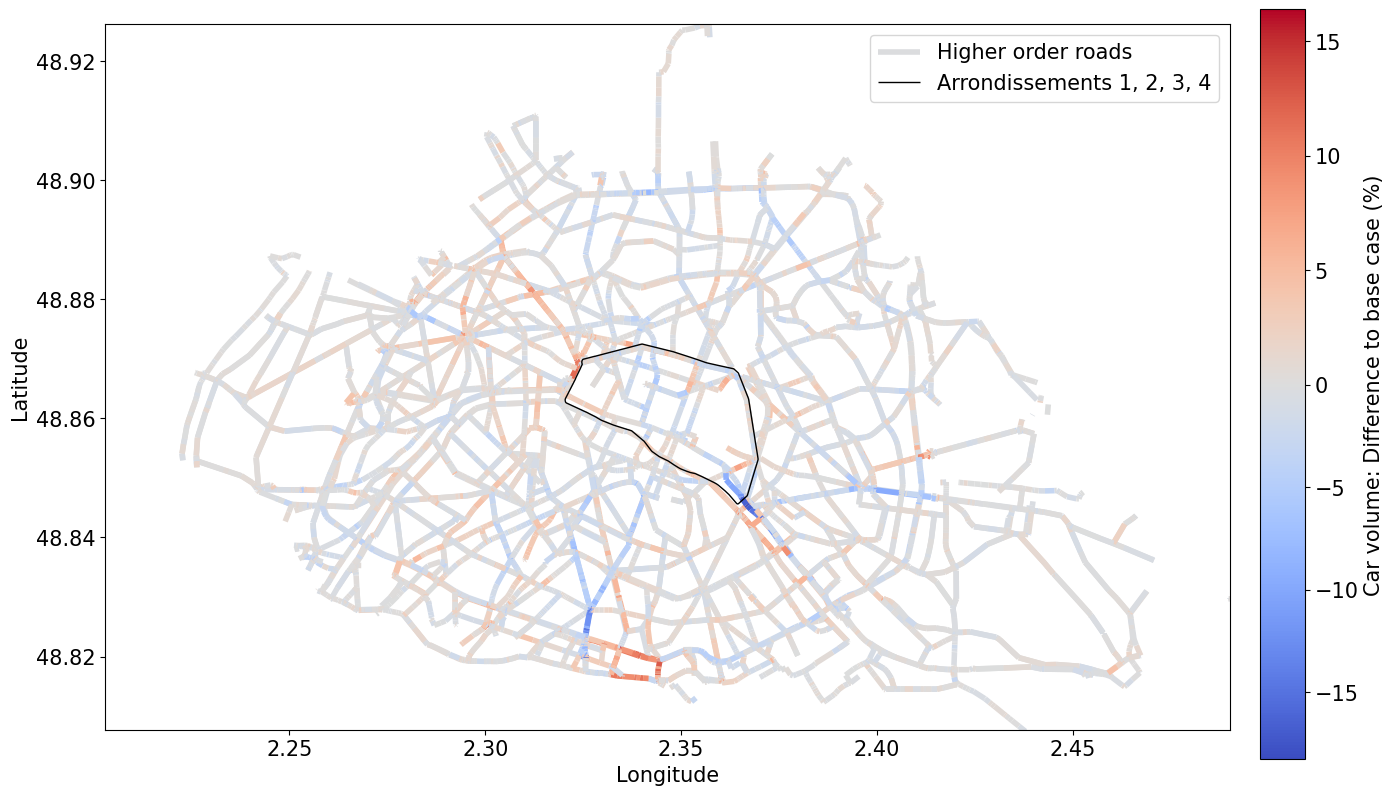

In [24]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from shapely.geometry import Point, LineString, box
from matplotlib.colors import TwoSlopeNorm

from shapely.ops import unary_union
from mpl_toolkits.axes_grid1 import make_axes_locatable

districts = gpd.read_file("../../data/visualisation/districts_paris.geojson")

def list_to_string(integers, delimiter=', '):
    """
    Converts a list of integers into a string, with each integer separated by the specified delimiter.

    Parameters:
    integers (list of int): The list of integers to convert.
    delimiter (str): The delimiter to use between integers in the string.

    Returns:
    str: A string representation of the list of integers.
    """
    return delimiter.join(map(str, integers))

# Define the intersects function
def intersects_target(row, target_districts):
    return target_districts.geometry.apply(lambda geom: geom.intersects(row.geometry)).any()
    
def plot_simulation_output(gdf_input, districts_of_interest: list, column_to_plot = "og_vol_car_change_predicted"):    
    gdf = gdf_input.copy()
    x_min = gdf.total_bounds[0] + 0.05
    y_min = gdf.total_bounds[1] + 0.05
    x_max = gdf.total_bounds[2]
    y_max = gdf.total_bounds[3]
    bbox = box(x_min, y_min, x_max, y_max)
    
    # Filter the network to include only the data within the bounding box
    gdf = gdf[gdf.intersects(bbox)]
    
    # Set up the plot
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    
    gdf = gdf[gdf["og_highway"].isin([1, 2, 3])]
    
    target_districts = districts[districts['c_ar'].isin(districts_of_interest)]
    # gdf['intersects_target_districts'] = gdf.apply(intersects_target, axis=1, target_districts=target_districts)
    # Use TwoSlopeNorm for custom normalization
    norm = TwoSlopeNorm(vmin=gdf[column_to_plot].min(), vcenter=gdf[column_to_plot].median(), vmax=gdf[column_to_plot].max())
    
    # Plot the edges that intersect with target districts thicker
    gdf.plot(column=column_to_plot, cmap='coolwarm', linewidth=4, ax=ax, legend=False,
             norm=norm, label = "Higher order roads", zorder=2)
    
    # Add buffer to target districts to avoid overlapping with edges
    buffered_target_districts = target_districts.copy()
    buffered_target_districts['geometry'] = buffered_target_districts.buffer(0.0005)
    # Ensure the buffered_target_districts GeoDataFrame is in the same CRS
    if buffered_target_districts.crs != gdf.crs:
        buffered_target_districts.to_crs(gdf.crs, inplace=True)

    # Create a single outer boundary
    outer_boundary = unary_union(buffered_target_districts.geometry).boundary

    # Plot only the outer boundary
    gpd.GeoSeries(outer_boundary, crs=gdf.crs).plot(ax=ax, edgecolor='black', linewidth=1, label="Arrondissements " + list_to_string(districts_of_interest), zorder=4)

    # ax.set_aspect('equal')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    
    # Customize the plot with Times New Roman font and size 15
    plt.xlabel("Longitude", fontname='Times New Roman', fontsize=15)
    plt.ylabel("Latitude", fontname='Times New Roman', fontsize=15)

    # Customize tick labels
    ax.tick_params(axis='both', which='major', labelsize=10)
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontname('Times New Roman')
        label.set_fontsize(15)
    ax.legend(prop={'family': 'Times New Roman', 'size': 15})
    ax.set_position([0.1, 0.1, 0.75, 0.75])
    cax = fig.add_axes([0.87, 0.22, 0.03, 0.5])  # Manually position the color bar

    # Create the color bar
    sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
    sm._A = []
    cbar = plt.colorbar(sm, cax=cax)
    
    # Set color bar font properties
    cbar.ax.tick_params(labelsize=15)
    for t in cbar.ax.get_yticklabels():
        t.set_fontname('Times New Roman')
    cbar.ax.yaxis.label.set_fontname('Times New Roman')
    cbar.ax.yaxis.label.set_size(15)
    # if in_percentage:
    cbar.set_label('Car volume: Difference to base case (%)', fontname='Times New Roman', fontsize=15)
    # else:
    #     cbar.set_label('Car volume: Difference to base case (absolut)', fontname='Times New Roman', fontsize=15)
    # plt.savefig("results/difference_to_policies_in_zones_" + list_to_string(districts_of_interest, "_") + is_for_1pm, bbox_inches='tight')
    plt.show()

districts_of_interest = [1, 2, 3, 4]
plot_simulation_output(gdf, districts_of_interest=districts_of_interest, column_to_plot="og_vol_car_change_predicted")


/tmp/ipykernel_1515856/1706285333.py:59: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffered_target_districts['geometry'] = buffered_target_districts.buffer(0.0005)
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times N

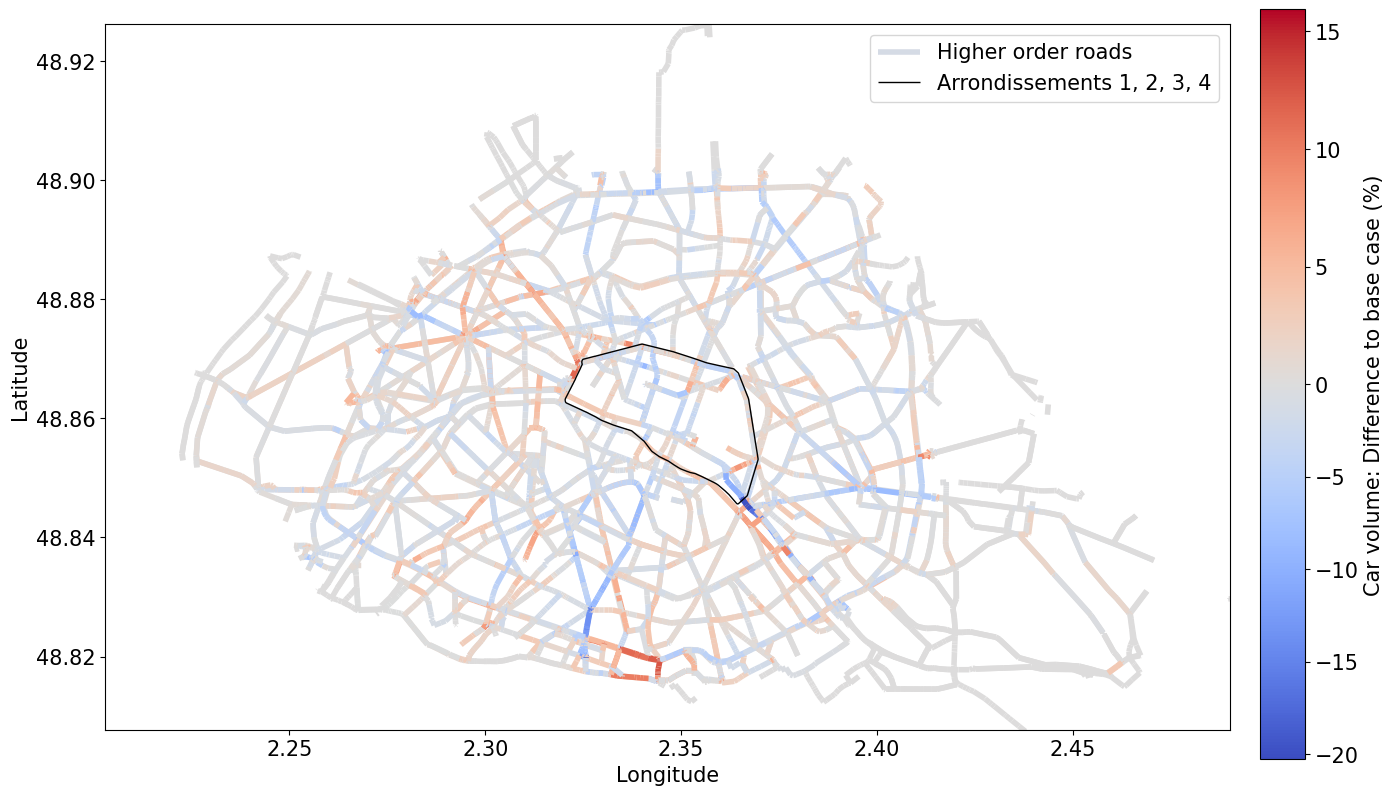

In [25]:
plot_simulation_output(gdf, districts_of_interest=districts_of_interest, column_to_plot='og_vol_car_change_actual')